#                   Sentiment Analisys
#                   Ilan Moshe (024176398)
                

## This files handles products reviews as collected from customers feedback from reviews, surveys, and social media as described below :


###1.  Load a dataset of customers product review. This dataset contains a list of products with

*   Product ID
*   Text written by the customer that will be used for sentiment analysis
*   Score raiting of the product (values 1-5),



### Used for sentiment analysis by the model I .There is not real ground truth indication in this file because we are not training the model , but I use the 1-5 stars indication of the user to valudate the prediction done of customer sentiment for the product

###2. Plot some graph explaining the dataset

###3.   Run customers textual reviews on the model created in the Fine_Tune_LLM_Model file for sentiment analysis


###4.    Check all review results per product to find the customer sentiment about each product , devide the results into three groups (excelent ,good and problematic products from the customers point of view). The relevant group is decided by number of positive feedbacks compared to the total numbers of reviews for each product.

###5. For results validation I compare the results to the user avarage Score ratings per product.

### Package installtion

In [1]:
!pip install peft

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

## Import Packaged

In [2]:
from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer)

from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig
import json
import shutil
import re as re
import torch
import plotly.express as px
import numpy as np
import gdown
from sklearn.metrics import accuracy_score
from pprint import pprint
from IPython.display import display, HTML
from transformers import AutoModelForSequenceClassification, AutoTokenizer

## Dowload data from GIT and google drive


*   Download the trained model for sentiment classfication
*   Download the CSV containing the customer reviews about the products



In [3]:
# Download the Model from GitHub
!git clone --filter=blob:none --sparse https://github.com/ilanmoshe52/NLP/
!unzip /content/NLP/fine_tuned_model.zip -d /content/fine_tuned_model
!rm -r NLP

Cloning into 'NLP'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 58 (delta 25), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (58/58), 25.47 KiB | 5.09 MiB/s, done.
Resolving deltas: 100% (25/25), done.
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (6/6), 3.09 MiB | 13.87 MiB/s, done.
Archive:  /content/NLP/fine_tuned_model.zip
  inflating: /content/fine_tuned_model/id2label.json  
  inflating: /content/fine_tuned_model/adapter_model.safetensors  
  inflating: /content/fine_tuned_model/label2id.json  
  inflating: /content/fine_tuned_model/vocab.txt  
  inflating: /content/fine_tuned_model/adapter_config.json  
  inflating: /content/fine_tuned_model/tokenizer.json  
  inflating: /content/fine_tuned_model/t

In [4]:
# Download the file from google drive used to hold Product customer reviews file from
gdown.download(f'https://drive.google.com/file/d/1l5IgXWmFmL5mIBTw-FXPmMz3sm1OmHql/view?usp=sharing', 'filtered_reviews.csv', quiet=False , fuzzy = True)


Downloading...
From: https://drive.google.com/uc?id=1l5IgXWmFmL5mIBTw-FXPmMz3sm1OmHql
To: /content/filtered_reviews.csv
100%|██████████| 251k/251k [00:00<00:00, 46.8MB/s]


'filtered_reviews.csv'

## Load the model from GIT ( Previously tuned in the Fine_Tune_LLM_Model file)

In [5]:
# how to load peft model from hub for inference
model_id = 'fine_tuned_model'
config = PeftConfig.from_pretrained(model_id)

In [6]:
# Load id2label and label2id mappings
with open('/content/fine_tuned_model/id2label.json', 'r') as f:
    id2label = json.load(f)
with open('/content/fine_tuned_model/label2id.json', 'r') as f:
    label2id = json.load(f)

In [7]:
inference_model = AutoModelForSequenceClassification.from_pretrained(
    config.base_model_name_or_path, num_labels=2, id2label=id2label, label2id=label2id
)
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)
model = PeftModel.from_pretrained(inference_model, model_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

# Handle the product review data

Load the product review csv file

In [8]:
import pandas as pd

encodings = ['utf-8', 'latin1', 'iso-8859-1', 'cp1252']

# Load the CSV file
for encoding in encodings:
    try:
        df = pd.read_csv('/content/filtered_reviews.csv', encoding=encoding ,  on_bad_lines='warn')
        print(f"Successfully read the file with {encoding} encoding.")
        break
    except UnicodeDecodeError as e:
        print(f"Failed to read with {encoding} encoding. Error: {e}")

# Display the first few rows of the DataFrame
df.head()


Successfully read the file with utf-8 encoding.


,ProductId,Text,Score
0,B004PEGIJY,"At the time of this review, Zevia Grape is not...",5
1,B004PEGIJY,I want to say up front that I hate the taste o...,5
2,B004PEGIJY,If I was a fan of grape soda then I would cert...,4
3,B004PEGIJY,CAUTION...DO NOT use ice cubes in any Zevia so...,4
4,B004PEGIJY,"I bought these for my husband at WF, because h...",5


### Clean the data from special characters

In [9]:
# Function to remove special tags from the dataset
def clean_text(text):
    import re
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    return text

In [10]:
df['Text']=df['Text'].apply(lambda cw : clean_text(cw))
df.head()

,ProductId,Text,Score
0,B004PEGIJY,at the time of this review zevia grape is not ...,5
1,B004PEGIJY,i want to say up front that i hate the taste o...,5
2,B004PEGIJY,if i was a fan of grape soda then i would cert...,4
3,B004PEGIJY,cautiondo not use ice cubes in any zevia sodai...,4
4,B004PEGIJY,i bought these for my husband at wf because he...,5


In [11]:
import pandas as pd
import plotly.graph_objects as go

data = df

# Initialize a dictionary to store the ratings count for each product
ratings_dict = {}

# Aggregate star ratings for each product
for product_id in data['ProductId'].unique():
    product_data = data[data['ProductId'] == product_id]
    ratings = product_data['Score'].value_counts().sort_index()
    ratings_dict[product_id] = ratings

# Prepare data for plotting
products = list(ratings_dict.keys())
ratings = {str(i) + ' Stars': [ratings_dict[product].get(i, 0) for product in products] for i in range(1, 6)}

# Create traces for each star rating
traces = []
for rating, counts in ratings.items():
    traces.append(go.Bar(
        x=products,
        y=counts,
        name=rating
    ))

# Create the figure
fig = go.Figure(data=traces)

# Update layout to make it scrollable
fig.update_layout(
    title='Customers Score Rating Distribution (Zoom is available)',
    xaxis=dict(
        title='Products',
        tickmode='linear'
    ),
    yaxis=dict(
        title='Number of Reviews'
    ),
    barmode='group',
    bargap=0.15,  # Gap between bars of adjacent location coordinates.
    bargroupgap=0.1,  # Gap between bars of the same location coordinates.
    xaxis_tickangle=-45,
    height=600,
    width=1200
)

# Add scroll functionality
fig.update_layout(
    xaxis=dict(
        rangeslider=dict(visible=True),
        type="category"
    )
)

# Show the figure
fig.show()


### We can see that each product has equal number of customer review in the dataset

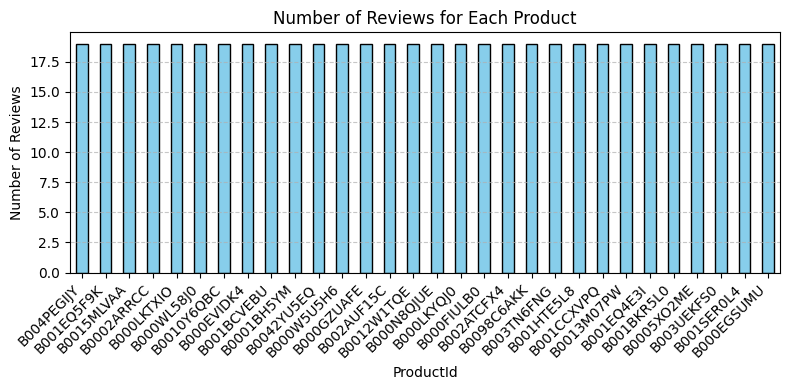

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

data = df

# Count the number of reviews for each ProductId
review_counts = data['ProductId'].value_counts()

# Plot bar chart
plt.figure(figsize=(8, 4))
review_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Reviews for Each Product')
plt.xlabel('ProductId')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Group all customers reivews per product

In [13]:
# Group by 'ProductId'
grouped = df.groupby('ProductId')

# Create a dictionary with ProductId as key and list of lists of 'Text' as values
product_reviews_dict = {
    product_id: {
        'Texts': group['Text'].tolist(),
        'Scores': group['Score'].tolist()
    }
    for product_id, group in grouped
}


### Calculate the average score by product ( This will be used as reference )

In [14]:
# Calculate the average score by product
avg_scores = df.groupby('ProductId')['Score'].mean().reset_index()
avg_scores['Score'] = avg_scores['Score'] * 20

### General product customer satisfaction by user stars review

### Run Customers reviews of each item on the model

In [15]:
# copy the original dictionary
updated_dict = {
    key: (value if isinstance(value, dict) else {'OriginalValue': value, 'predictions': 0})
    for key, value in product_reviews_dict.items()
}

# Add 'MeanValue' to existing dictionaries
for key, value in product_reviews_dict.items():
    if isinstance(value, dict) and 'predictions' not in value:
        value['predictions'] = 0

for key, value in updated_dict.items():

  texts = product_reviews_dict[key]['Texts']

  # Tokenize the input texts
  inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

  # Run the model
  with torch.no_grad():
      outputs = model(**inputs)

  # Get the logits and convert to probabilities (optional)
  logits = outputs.logits
  probs = torch.nn.functional.softmax(logits, dim=-1)

  # Get the predicted class indices
  predictions = torch.argmax(logits, dim=-1)

  # Update the 'predictions' field in the dictionary
  updated_dict[key]['predictions'] = predictions



#### Calculate the positive feedback predicted by the model per product and possitive feeback calculated by user rating per product as reference

In [16]:
summary_dict = {}
total_true = 0

for index, (key, value) in enumerate(updated_dict.items()):
    precentage =  np.sum(list(value['predictions']))
    total_true += precentage
    length =  len(value['predictions'])
    scores_avg = np.sum(list(value['Scores']))
    summary_dict[index] = {
        'ProductId': key,
        'Prediction_Positive_Feedback': precentage/length,
        'Avg_Customer_Star_Ratings':  scores_avg/(length*5),
        'Number Of Items':  length    }

    #print('precentage :', str(precentage/length) , str(scores_avg/(length*5)), str(len(value['Texts'])))

df = pd.DataFrame(summary_dict)
df_transposed = df.T
df_transposed

,ProductId,Prediction_Positive_Feedback,Avg_Customer_Star_Ratings,Number Of Items
0,B0001BH5YM,0.947368,1.0,19
1,B0002ARRCC,0.421053,0.694737,19
2,B0005XO2ME,0.578947,0.473684,19
3,B000EGSUMU,0.684211,0.831579,19
4,B000EVIDK4,0.894737,0.936842,19
5,B000FIULB0,0.578947,0.810526,19
6,B000GZUAFE,0.789474,0.905263,19
7,B000LKTXIO,0.789474,0.831579,19
8,B000LKYQJ0,0.842105,0.831579,19
9,B000N8QJUE,0.368421,0.494737,19


# Define the following scale for product status :
  ### - (0 - 50%)        - Products that are problematic and discontinued
  ### - (51% - 80%)  - Products that need to be upgraded
  ### - (81% - 100%) - Excelent Products


In [17]:
# Initialize the dictionary with empty lists for each category
score_dict = {
    'Problematic': [],
    'Good': [],
    'Excellent': []
}

for i in range(len(df_transposed)):
#
    product_id  = df_transposed['ProductId'][i]
    precentage  = df_transposed['Prediction_Positive_Feedback'][i]
    if 0 <= precentage <= 0.5:
        score_dict['Problematic'].append(product_id)
    elif 0.51 <= precentage <= 0.8:
        score_dict['Good'].append(product_id)
    elif 0.81 <= precentage <= 1:
        score_dict['Excellent'].append(product_id)



#### Create a plot the sumarized the list of excelete , good and poor products rated by user sentiment analysis ( if hoover above this graph , products ids is available )

In [18]:
import plotly.graph_objects as go

# Sample dictionary
data =score_dict

# Prepare data for plotting
labels = list(data.keys())
values = [len(items) for items in data.values()]

# Create compact hover text
def create_hover_text(items, max_items=15):
    if len(items) > max_items:
        items = items[:max_items] + ['...']  # Truncate and indicate more items
    return "<br>".join([f"Item {i+1}: {item}" for i, item in enumerate(items)])

hover_texts = [f'{label}: {len(items)} items<br>{create_hover_text(items)}' for label, items in data.items()]

# Create the pie chart
fig = go.Figure(data=[go.Pie(
    labels=labels,
    values=values,
    hovertext=hover_texts,  # Custom hover text
    hoverinfo='label+value+percent+text',  # Show label, value, and percentage on hover
    textinfo='label+value',  # Show label and value on the chart
    hole=0.5  # For a donut chart, use hole parameter
)])

# Update layout for better visuals
fig.update_layout(
    title_text='Distribution of Categories (Hoover over to see Product Data)',
    annotations=[dict(text='Categories', x=0.5, y=0.5, font_size=20, showarrow=False)]
)

# Show the plot
fig.show()


#### Create bar plot of each product and user satisfaction scores based on the sentiment analysis ( on the left ) and on start ratings (on the right )

In [19]:
from plotly.subplots import make_subplots
fig1 = px.bar(df_transposed, x='ProductId', y='Prediction_Positive_Feedback', title='Final')
fig2 = px.bar(df_transposed, x='ProductId', y='Avg_Customer_Star_Ratings', title='Average Score by Product')
fig = make_subplots(rows=1, cols=2, subplot_titles=('Scores Based on Customer Sentiment Analisys', 'Scores Based on Star Rating Customer Avarage Scores'))

# Add bar charts to subplots
fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig2.data[0], row=1, col=2)

# Update layout
fig.update_layout(title_text='Compare between Model Predictions and customers Star Rating Avarage Score ')

# Show plot
fig.show()

### Analyze the difference between both graphs by calculate the max , min , std , var and mean of the difference between expected scores (rated by users by start rating of the product ) , and the predicted score of the model ( Rated by the users with text )

In [20]:
# Calculate the difference between the two columns
arr =  np.abs(df_transposed['Avg_Customer_Star_Ratings'] -  df_transposed['Prediction_Positive_Feedback'])

# Compute statistics on the difference
max_diff = arr.max()
min_diff = arr.min()
std_diff = arr.std()
var_diff = arr.var()
mean_diff = arr.mean()

# Print the results
display(HTML(f"<h3>Maximum Difference: {max_diff}</h3>"))
display(HTML(f"<h3>Minimum Difference: {min_diff}</h3>"))
display(HTML(f"<h3>Variance of Difference: {var_diff}</h3>"))
display(HTML(f"<h3>Standard Deviation of Difference: {std_diff}</h3>"))
display(HTML(f"<h3>Mean Difference: {mean_diff}</h3>"))

# We can see the following conclusions:

###1)   All statistics values indicating the differences between the predictad values from user reviews and the star values assign by the users are fairly small
###2)   The mean difference between the predicted and "ground truth" rated by user stars for each product is calculated to be 13% where the accuracy results for the model is 88%. this means that the results accuracy is very similar to the model accuracy (100-13 = 87% vs 88% as trained )

